# This time train is using the full df for the future forecasting
train = df
len(train)### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
KEY = "e46970bde5460c8e6caece2452083771f7320e41"

In [3]:
df_master = pdr.get_data_tiingo('AAPL', api_key = KEY)
df_master.to_csv('AAPL.csv')
df_master=pd.read_csv('AAPL.csv')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1257 non-null   object 
 1   date         1257 non-null   object 
 2   close        1257 non-null   float64
 3   high         1257 non-null   float64
 4   low          1257 non-null   float64
 5   open         1257 non-null   float64
 6   volume       1257 non-null   int64  
 7   adjClose     1257 non-null   float64
 8   adjHigh      1257 non-null   float64
 9   adjLow       1257 non-null   float64
 10  adjOpen      1257 non-null   float64
 11  adjVolume    1257 non-null   int64  
 12  divCash      1257 non-null   float64
 13  splitFactor  1257 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.6+ KB


In [4]:
df_master.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-01-06 00:00:00+00:00,100.70,102.37,99.8700,100.56,68457388,23.320970,23.707723,23.128752,23.288548,273829552,0.0,1.0
1,AAPL,2016-01-07 00:00:00+00:00,96.45,100.13,96.4300,98.68,81094428,22.336719,23.188965,22.332087,22.853161,324377712,0.0,1.0
2,AAPL,2016-01-08 00:00:00+00:00,96.96,99.11,96.7600,98.55,70798016,22.454829,22.952744,22.408511,22.823055,283192064,0.0,1.0
3,AAPL,2016-01-11 00:00:00+00:00,98.53,99.06,97.3400,98.97,49739377,22.818423,22.941165,22.542833,22.920322,198957508,0.0,1.0
4,AAPL,2016-01-12 00:00:00+00:00,99.96,100.69,98.8399,100.55,49154227,23.149595,23.318654,22.890192,23.286232,196616908,0.0,1.0


In [5]:
df_master.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2020-12-24 00:00:00+00:00,131.97,133.460,131.1000,131.32,54930064,131.97,133.460,131.1000,131.32,54930064,0.0,1.0
1253,AAPL,2020-12-28 00:00:00+00:00,136.69,137.340,133.5100,133.99,123124632,136.69,137.340,133.5100,133.99,123124632,0.0,1.0
1254,AAPL,2020-12-29 00:00:00+00:00,134.87,138.789,134.3409,138.05,121047324,134.87,138.789,134.3409,138.05,121047324,0.0,1.0
1255,AAPL,2020-12-30 00:00:00+00:00,133.72,135.990,133.4000,135.58,96452124,133.72,135.990,133.4000,135.58,96452124,0.0,1.0
1256,AAPL,2020-12-31 00:00:00+00:00,132.69,134.740,131.7200,134.08,99116586,132.69,134.740,131.7200,134.08,99116586,0.0,1.0


In [6]:
#df1 = df_master.reset_index()['close']

In [7]:
df = df_master[['date','close']].copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1257 non-null   object 
 1   close   1257 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [9]:
df['date']= pd.to_datetime(df['date'])

In [10]:
df['date'].dt.strftime('%Y-%m-%d')

0       2016-01-06
1       2016-01-07
2       2016-01-08
3       2016-01-11
4       2016-01-12
           ...    
1252    2020-12-24
1253    2020-12-28
1254    2020-12-29
1255    2020-12-30
1256    2020-12-31
Name: date, Length: 1257, dtype: object

In [11]:
df.set_index('date', inplace = True)

<AxesSubplot:xlabel='date'>

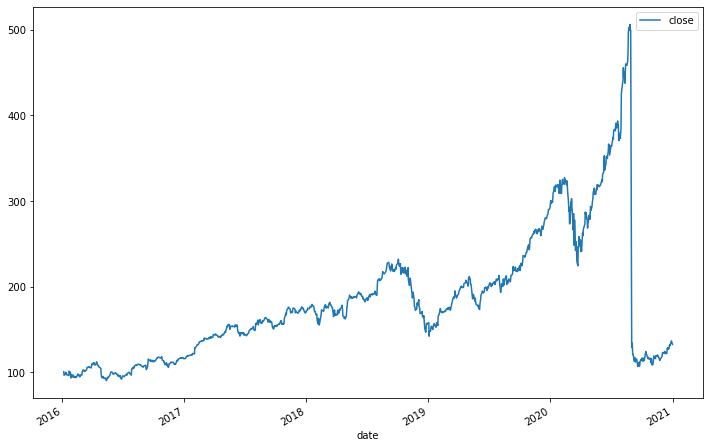

In [12]:
df.plot(figsize=(12,8))

In [13]:
len(df)

1257

In [14]:
test_size =  int(len(df)*0.35)
test_ind = len(df)- test_size

In [15]:
test_size

439

In [16]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [17]:
print(len(train))
print(len(test))

818
439


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [19]:
n_input = 100
n_features = 1
n_batch_size = 1

train_generator = TimeseriesGenerator(train, train, 
                                length = n_input, 
                                batch_size = n_batch_size)

test_generator = TimeseriesGenerator(test, test, 
                                           length = n_input, 
                                           batch_size = n_batch_size)

In [20]:
print(len(train_generator))
print(len(test_generator))

718
339


In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (n_input,n_features)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_generator, epochs = 2 ,
            validation_data = test_generator)

Epoch 1/2
718/718 [==============================] - 62s 86ms/step - loss: 0.0049 - val_loss: 0.2112
Epoch 2/2
718/718 [==============================] - 64s 89ms/step - loss: 0.0023 - val_loss: 0.0755: 1s


<AxesSubplot:>

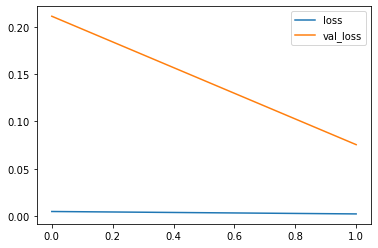

In [23]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [26]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))   # stepping stone value

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0])                # predict and save in list
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1) # next value for prediction

In [27]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, 
                          columns=['Prediction'])

In [28]:
df_predict

,Prediction
date,
2020-08-11 00:00:00+00:00,188.146312
2020-08-12 00:00:00+00:00,188.597583
2020-08-13 00:00:00+00:00,188.335170
2020-08-14 00:00:00+00:00,187.599742
2020-08-17 00:00:00+00:00,186.612831
...,...
2020-12-24 00:00:00+00:00,136.675605
2020-12-28 00:00:00+00:00,136.307633
2020-12-29 00:00:00+00:00,135.942280


In [29]:
df_test = pd.concat([df,df_predict], axis=1)

In [30]:
df_test

,close,Prediction
date,,
2016-01-06 00:00:00+00:00,100.70,NaN
2016-01-07 00:00:00+00:00,96.45,NaN
2016-01-08 00:00:00+00:00,96.96,NaN
2016-01-11 00:00:00+00:00,98.53,NaN
2016-01-12 00:00:00+00:00,99.96,NaN
...,...,...
2020-12-24 00:00:00+00:00,131.97,136.675605
2020-12-28 00:00:00+00:00,136.69,136.307633
2020-12-29 00:00:00+00:00,134.87,135.942280


In [31]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])) #error acceptable?

115.68681750575426

In [32]:
df_test.head()

,close,Prediction
date,,
2016-01-06 00:00:00+00:00,100.70,NaN
2016-01-07 00:00:00+00:00,96.45,NaN
2016-01-08 00:00:00+00:00,96.96,NaN
2016-01-11 00:00:00+00:00,98.53,NaN
2016-01-12 00:00:00+00:00,99.96,NaN


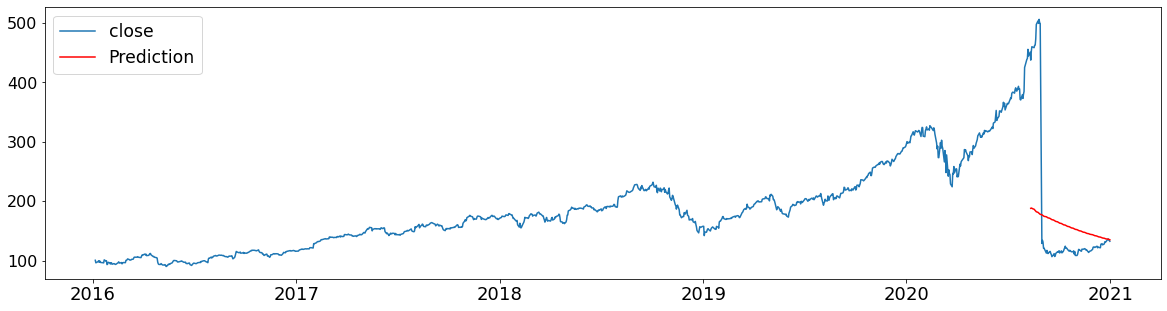

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['close'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(["close", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [34]:
# This time train is using the full df for the future forecasting
train = df
len(train)

1257

In [35]:
scaler.fit(train)
train = scaler.transform(train)

In [37]:
generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

In [38]:
model.fit(generator,epochs=2)

Epoch 1/2
1157/1157 [==============================] - 95s 82ms/step - loss: 0.0031
Epoch 2/2
1157/1157 [==============================] - 91s 79ms/step - loss: 0.0037


In [45]:
pred_list = []
n_future_length = 30   # 30 days
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_future_length):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [52]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0, n_future_length + 1) ]
future_dates = pd.DataFrame(index = add_dates[1:],
                            columns = df.columns)

In [57]:
len(future_dates)

30

In [54]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_future_length:].index, 
                          columns=['Prediction'])

In [55]:
df_projected = pd.concat([df,df_predict], axis=1)

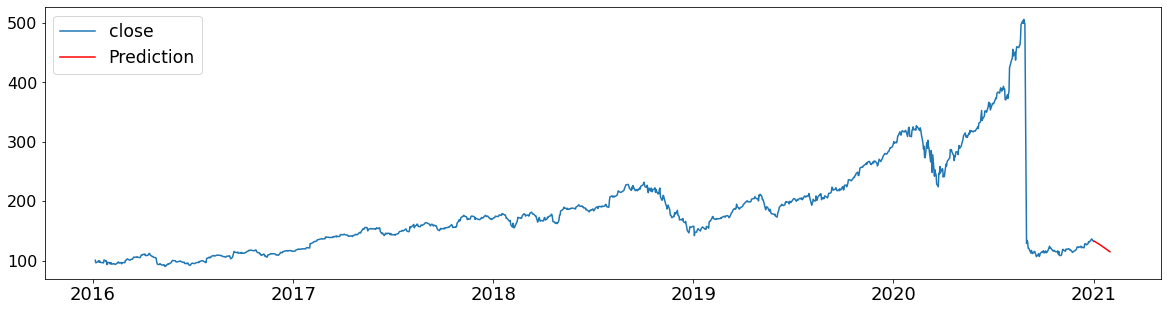

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(df_projected.index, df_projected['close'])
plt.plot(df_projected.index, df_projected['Prediction'], color='r')
plt.legend(["close", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()